In [1]:
%matplotlib inline

1


In [8]:
import numpy as np
import pandas as pd
import queue
from multiprocessing import Pool
import os

import sys
backtest_dir = 'C://backtest/backtest/'
if backtest_dir not in sys.path:
    sys.path.insert(0, backtest_dir)
    
from Backtest import *
from BayesianOptimization import *
from Backtest.open_json_gz_files import open_json_gz_files
from Backtest.generate_bars import generate_bars

---------------------------------
MACD_BOLLStrategy_13_33_153_0.1
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-08-07 23:00:00
---------------------------------
Running Backtest...
---------------------------------


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 2.9528726405
Sortino Ratio: 5.2749689931
Information Ratio: 1.5106203692
Max Drawdown: 0.2719435138
Max Drawdown Duration: 307900
Total Returns: 2.7196747368
Annualized Returns: 3.4948438748
Compound Annual Growth Rate: 4.4089361134
---------------------------------
Trades: 76
Trade Winning: 35.53%
Average Trade: 2.17%
Average Win: 9.01%
Average Loss: -1.61%
Best Trade: 32.06%
Worst Trade: -6.27%
Worst Trade Date: 0 days 04:00:00
Avg Days in Trade: 1 days 09:34:44
---------------------------------


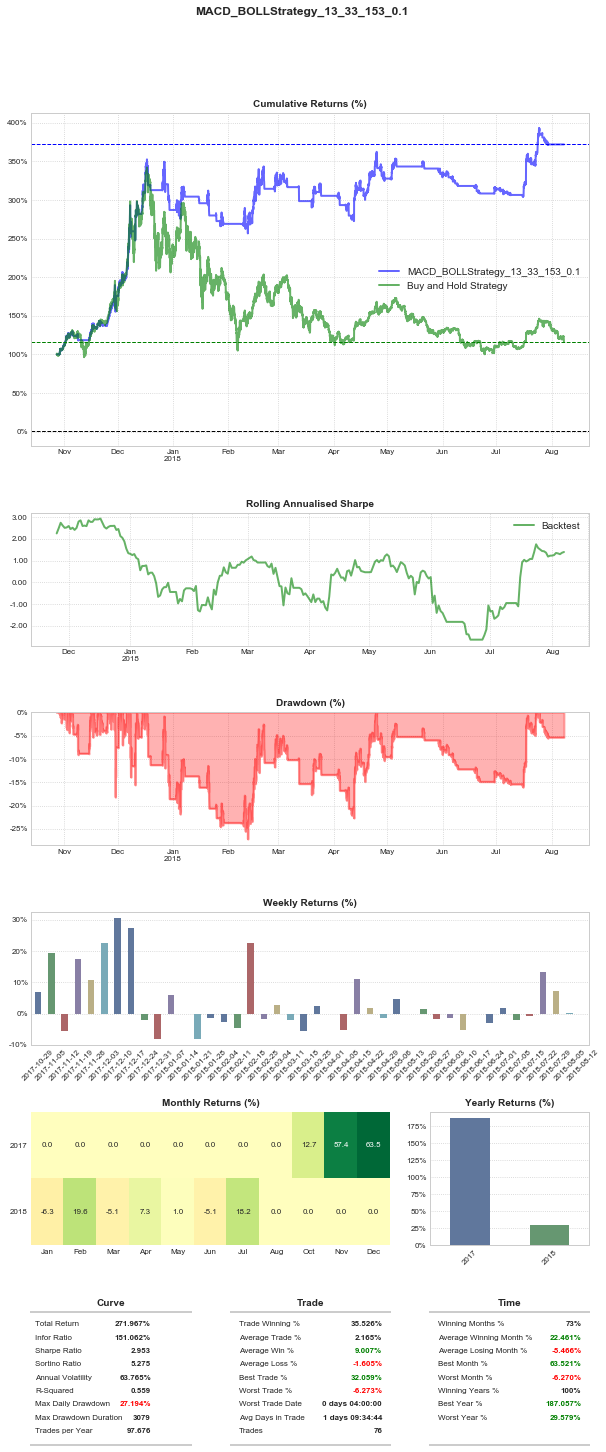

In [16]:

class MACD_BOLLStrategy(Strategy):
    def __init__(self, config, events, data_handler,
                 short_window = 10, long_window = 40,
                 window = 10, a = 2):
        self.config = config
        self.data_handler = data_handler
        self.tickers = self.config['tickers']
        self.events = events
        self.holdinds = self._calculate_initial_holdings()

        self.short_window = short_window
        self.long_window = long_window

        self.window = window
        self.a = a

    def _calculate_initial_holdings(self):
        holdings = {}
        for s in self.tickers:
            holdings[s] = "EMPTY"
        return holdings

    def generate_signals(self, event):
        if event.type == EventType.MARKET:
            ticker = event.ticker
            bar_date = event.timestamp
            bars_MACD = self.data_handler.get_latest_bars_values(
                ticker, "close", N=self.long_window
            )
            bars_BOLL = self.data_handler.get_latest_bars_values(
                ticker, "close", N=self.window
            )

            if (bars_MACD is not None and bars_MACD != []) and (bars_BOLL is not None and bars_BOLL != []):
                short_ma = np.mean(bars_MACD[-self.short_window:])
                long_ma  = np.mean(bars_MACD[-self.long_window:])

                bars_mean = np.mean(bars_BOLL)
                bars_std = np.std(bars_BOLL)
                upperbound = bars_mean + self.a * bars_std
                lowerbound = bars_mean - self.a * bars_std

                if (short_ma > long_ma and event.close > upperbound) and self.holdinds[ticker] == "EMPTY":
                    self.generate_buy_signals(ticker, bar_date, "LONG")
                    self.holdinds[ticker] = "HOLD"
                elif (short_ma < long_ma or event.close < lowerbound) and self.holdinds[ticker] == "HOLD":
                    self.generate_sell_signals(ticker, bar_date, "SHORT")
                    self.holdinds[ticker] = "EMPTY"


def run_backtest(config, trading_data, ohlc_data, short_window = 10, long_window = 40, window = 10, a = 2):
    config['title'] = "MACD_BOLLStrategy" + "_" + str(short_window) + "_" + str(long_window) + "_" + str(window) + "_" + str(a)
    print("---------------------------------")
    print(config['title'])
    print("---------------------------------")

    events_queue = queue.Queue()

    data_handler = OHLCDataHandler(
        config, events_queue,
        trading_data = trading_data, ohlc_data = ohlc_data
    )
    strategy = MACD_BOLLStrategy(config, events_queue, data_handler,
                            short_window=short_window, long_window=long_window,
                            window = window, a = a)

    backtest = Backtest(config, events_queue, strategy,
                        data_handler= data_handler)

    results = backtest.start_trading()
    return backtest, results


    # dict_ans = {
    #     "short_window": [short_window],
    #     "long_window": [long_window],
    #     "Sharpe Ratio": [results['sharpe']],
    #     "Total Returns": [(results['cum_returns'][-1] - 1)],
    #     "Max Drawdown": [(results["max_drawdown"] * 100.0)],
    #     "Max Drawdown Duration": [(results['max_drawdown_duration'])],
    #     "Trades": [results['trade_info']['trading_num']],
    #     "Trade Winning": [results['trade_info']['win_pct']],
    #     "Average Trade": [results['trade_info']['avg_trd_pct']],
    #     "Average Win": [results['trade_info']['avg_win_pct']],
    #     "Average Loss": [results['trade_info']['avg_loss_pct']],
    #     "Best Trade": [results['trade_info']['max_win_pct']],
    #     "Worst Trade": [results['trade_info']['max_loss_pct']],
    #     "Worst Trade Date": [results['trade_info']['max_loss_dt']],
    #     "Avg Days in Trade": [results['trade_info']['avg_dit']]
    # }
    # return pd.DataFrame(dict_ans)


if __name__ == "__main__":
    config = {
        "csv_dir": "C:/backtest/Binance",
        "out_dir": "C:/backtest/results/MACD_BOLLStrategy",
        "title": "MACD_BOLLStrategy",
        "is_plot": True,
        "save_plot": True,
        "save_tradelog": True,
        "start_date": pd.Timestamp("2017-04-01T00:0:00", freq="60" + "T"),  # str(freq) + "T"
        "end_date": pd.Timestamp("2018-09-01T00:00:00", freq="60" + "T"),
        "equity": 1.0,
        "freq": 60,  # min
        "commission_ratio": 0.001,
        "suggested_quantity": None,     # None or a value
        "max_quantity": None,           # None or a value, Maximum purchase quantity
        "min_quantity": None,           # None or a value, Minimum purchase quantity
        "min_handheld_cash": None,      # None or a value, Minimum handheld funds
        "exchange": "Binance",
        "tickers": ['BTCUSDT']
    }


    # trading_data = {}
    # for ticker in config['tickers']:
    #     # trading_data[ticker] = open_gz_files(config['csv_dir'], ticker)
    #     trading_data[ticker] = pd.read_hdf(config['csv_dir'] + '\\' + ticker + '.h5', key=ticker)

    ohlc_data = {}
    for ticker in config['tickers']:
        # ohlc_data[ticker] = generate_bars(trading_data, ticker, config['freq'])
        ohlc_data[ticker] = pd.read_hdf(config['csv_dir'] + '\\' + ticker +'_OHLC_60min.h5', key=ticker)

    trading_data = None

    backtest, results = run_backtest(config, trading_data, ohlc_data, short_window = 13, long_window = 33, window = 153, a = 0.1)




In [15]:
results['trade_info']

{'trading_num': 76,
 'win_pct': 0.35526315789473684,
 'avg_trd_pct': 0.021650296837237803,
 'avg_win_pct': 0.09006981253876133,
 'avg_loss_pct': -0.016050252630948603,
 'max_win_pct': 0.3205903464605337,
 'max_loss_pct': -0.0627254571174662,
 'max_loss_dt': Timedelta('0 days 04:00:00'),
 'avg_dit': Timedelta('1 days 09:34:44')}

In [5]:
mid_time = pd.Timestamp("2018-04-01")

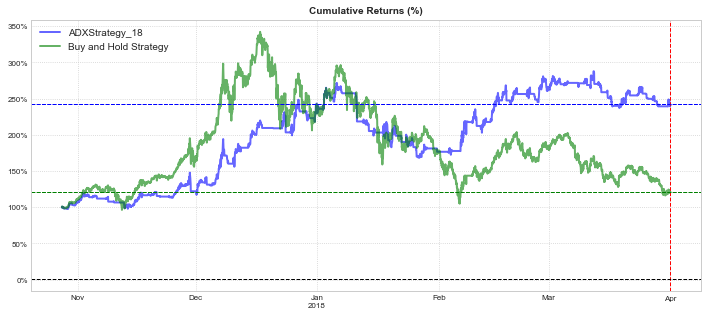

In [6]:
backtest.performance.plot_cum_returns(results, mid_time=mid_time)

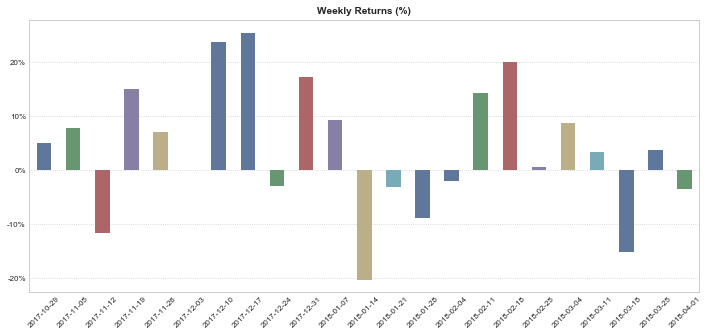

In [7]:
backtest.performance.plot_weekly_returns(results)

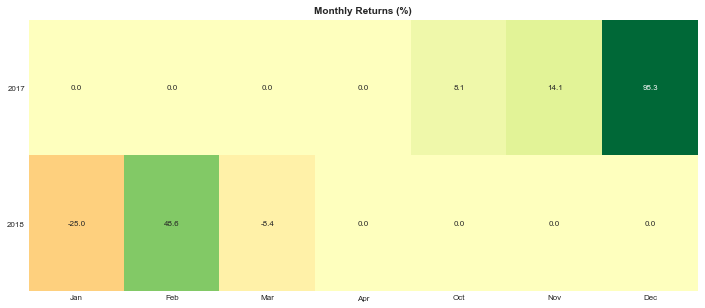

In [8]:
backtest.performance.plot_monthly_returns(results)

In [23]:
results['rolling_return_month']

2017  10    0.081401
      11    0.141081
      12    0.953353
2018  1    -0.250235
      2     0.485926
      3    -0.084141
      4     0.000000
dtype: float64

In [5]:
close = ohlc_data[ticker]['close']

returns = close/close.shift(120) - 1

In [7]:
returns = returns.dropna()

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
returns.mean()

0.010774142100477082

In [20]:
sum(returns[-2000:]<-0)

1084

In [30]:
short = close/close.shift(24) - 1
short = short.iloc[120:]

In [27]:
long = close/close.shift(120) - 1
long = long.iloc[120:]

In [32]:
sum(short<long)

3557

In [31]:
sum(short>long)

3141

In [ ]:
short_ma = np.mean(bars[-self.short_window:])
long_ma  = np.mean(bars[-self.long_window:])

if short_ma > long_ma and self.holdinds[ticker] == "EMPTY":
    self.generate_buy_signals(ticker, bar_date, "LONG")
    self.holdinds[ticker] = "HOLD"
elif short_ma < long_ma and self.holdinds[ticker] == "HOLD":
    self.generate_sell_signals(ticker, bar_date, "SHORT")

In [136]:
datadict = {}
datadict['close'] = close_times
sum=1.0

datadict['sum']=pd.Series(sum,index=datadict['close'].index)
#    dictionary={str(datadict['open'].index[0]):sum}
#   result=pd.Series(dictionary)
shortime=45
longtime=60

datadict['return']=-1
datadict['longsum']=datadict['close'].rolling(longtime).sum()
datadict['shortsum']=datadict['close'].rolling(shortime).sum()
datadict['MAshortime']=datadict['shortsum']/shortime
datadict['MAlongtime']=datadict['longsum']/longtime
datadict['sub']=datadict['MAshortime']-datadict['MAlongtime']
datadict['flag']=(datadict['sub']>=0)*1
datadict['return']=datadict['flag'].shift(1)*(datadict['close']/datadict['close'].shift(1)-1)+1
datadict['fee']=(datadict['flag'].shift(1)!=datadict['flag'])*(-0.001)+1
datadict['return']=datadict['fee']*datadict['return']
datadict['sum']=datadict['return'].cumprod()
datadict['sum'][0]=sum
result=datadict['sum']

In [154]:
aa = datadict['return'].loc[datadict['return']>1]
aa.prod()

299924.68015143345

In [155]:
bb = datadict['return'].loc[datadict['return']<1]
bb.prod()

8.310805319106038e-06

In [152]:
aa.prod() * bb.prod()

2.49261562713371

In [153]:
aa = returns.loc[returns>1]
aa.prod()

1102525396.789557

In [156]:
bb = returns.loc[returns<1]
bb.prod()

0.0015974557737123767

In [1]:
import pandas as pd
import numpy as np
import talib
import h5py
import os
import matplotlib.pyplot as plt

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
csv_dir = "C:/backtest/Binance"
ticker = 'BTCUSDT'

In [3]:
ohlc_data = pd.read_hdf(csv_dir + '\\' + ticker + '_OHLC_60min.h5', key=ticker)

In [4]:
close = ohlc_data['close']

In [5]:
window = 120
times = close.index[window * 2: -(window//10)]
unit = pd.Timedelta("60Min")

In [6]:
close_pre_data = []
for timeind in times:
    now_close = close.loc[timeind]
    future_close = close.loc[timeind + unit: timeind + unit * (window/10)].as_matrix()
    close_pre_data.append(future_close / now_close - 1)
close_pre_data = np.asarray(close_pre_data)
close_pre_data = pd.DataFrame(close_pre_data, index=times)
close_pre_data.shape

(6566, 12)

In [25]:
# sell
sell1 = np.sum(close_pre_data.iloc[:,0:6] < 0, axis=1) > 3
sell2 = (np.sum(close_pre_data < 0, axis=1) > 8)
sell = np.logical_and(sell1, sell2) * 1.0
# buy
buy1 = np.sum(close_pre_data.iloc[:,0:6] > 0, axis=1) > 4
buy2 = np.logical_and((np.sum(close_pre_data > 0, axis=1) > 8), (np.sum(close_pre_data.iloc[:,0:6] > 0, axis=1) > 2))
buy = np.logical_and(buy1, buy2) * 1.0

signal = 1 * buy - 1 * sell

In [65]:
flag = pd.Series(0, index=signal.index)
for i in range(1,len(signal)):
    if signal.iloc[i] == 1:
        flag.iloc[i] = 1
    if signal.iloc[i] ==0 and flag.iloc[i-1] == 1:
        flag.iloc[i] = 1
    if signal.iloc[i] == -1:
        flag.iloc[i] = 0
    if signal.iloc[i] ==0 and flag.iloc[i-1] == 0:
        flag.iloc[i] = 0

In [78]:
close_times = close.loc[times]

In [106]:
returns = flag.shift(1) * (close_times/close_times.shift(1)-1) + 1

In [107]:
fee = (flag.shift(1) != flag) * (-0.001) + 1

In [108]:
returns = fee * returns
returns.iloc[0] = 1

In [120]:
cum_returns = returns.cumprod()

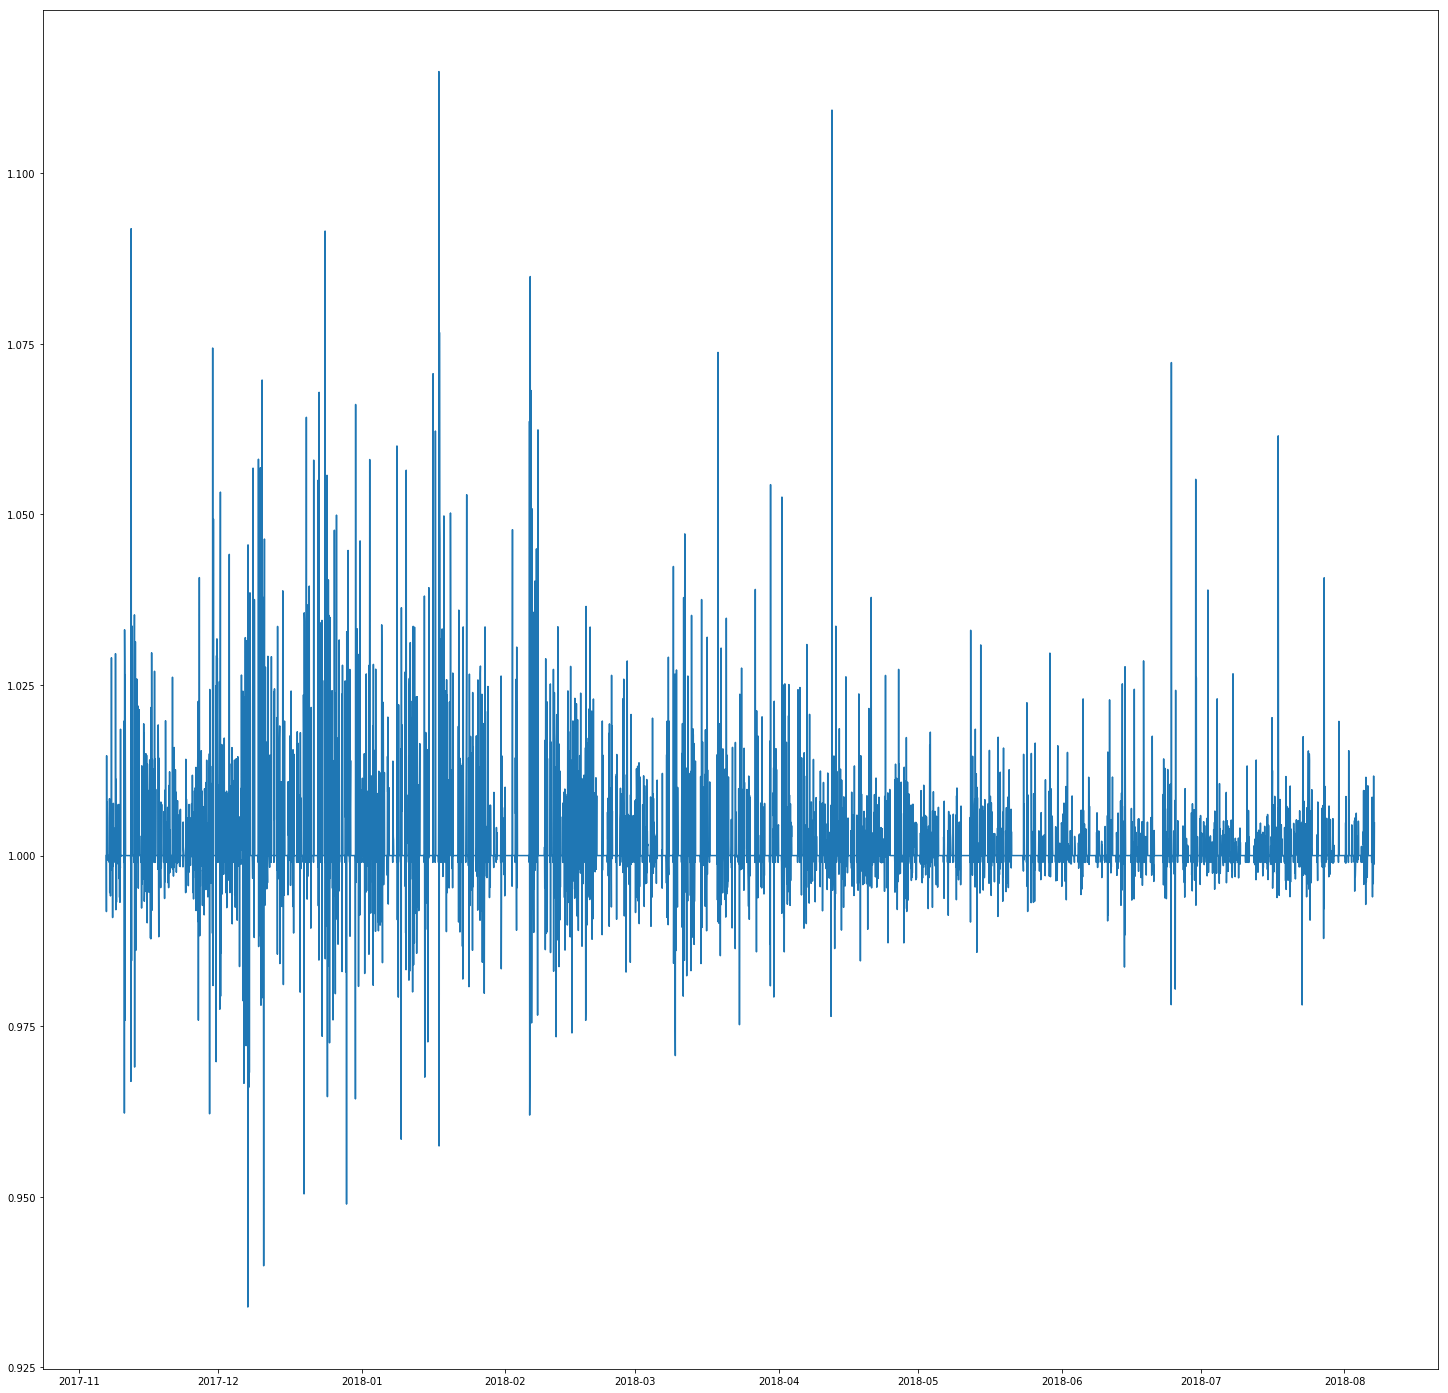

In [143]:
plt.figure(figsize=(25, 25))
plt.plot(returns)
plt.show()

In [196]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
from itertools import groupby
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

from Backtest.plot_results import *


class Performance(object):
    '''
    Calculating the backtest results and ploting the results.
    '''
    def __init__(self, config, portfolio_handler, data_handler, periods = 365):
        '''
        Parameters:
        config: the list of settings showed in Backtest
        portfolio_handler: class PortfolioHandler
        data_handler: class OHLCDataHandler
        periods: trading day of the year
        '''
        self.config = config
        self.portfolio_handler = portfolio_handler
        self.data_handler = data_handler
        self.equity = {}
        self.BNH_equity = {}
        self.periods = periods

    def update(self, timestamp):
        '''
        Update performance's equity for every tick
        '''
        self.equity[timestamp] = self.portfolio_handler.equity
        self.BNH_equity[timestamp] = self.portfolio_handler.BNH_equity

    def _create_drawdown(self, cum_returns):
        '''
        Calculate drawdown
        '''
        idx = cum_returns.index
        hwm = np.zeros(len(idx))

        for i in range(1, len(idx)):
            hwm[i] = max(hwm[i-1], cum_returns.iloc[i])

        dd = pd.DataFrame(index = idx)
        dd['Drawdown'] = (hwm - cum_returns) / hwm
        dd['Drawdown'].iloc[0] = 0.0
        dd['Duration'] = np.where(dd['Drawdown'] == 0, 0, 1)
        duration = max(sum(g) for k,g in groupby(dd['Duration']))
        return dd['Drawdown'], np.max(dd['Drawdown']), duration

    def _get_positions(self):
        positions = self.portfolio_handler.closed_positions
        if len(positions) == 0:
            return None
        else:
            return pd.DataFrame(positions)

    def get_results(self):
        """
        Return a dict with all important results & stats.
        
        includings:
            results['returns']
            results['daily_returns']
            results['equity']        
            results['tot_return']
            results['annual_return']
            results['cagr']
            results['rolling_sharpe']
            results['cum_returns']
            results['daily_cum_returns']
            results['drawdown']
            results['max_drawdown']
            results['max_drawdown_duration']
            results['sharpe']
            results['sortino']
            results['positions']
            results['trade_info'] = {
                "trading_num": 'Trades Number'
                "win_pct": 'Trade Winning %'
                "avg_trd_pct": 'Average Trade %'
                "avg_win_pct": 'Average Win %'
                "avg_loss_pct": 'Average Loss %'
                "max_win_pct": 'Best Trade %'
                "max_loss_pct": 'Worst Trade %'
                "max_loss_dt": 'Worst Trade Date'
                "avg_dit": 'Avg Days in Trade'
            }
        """
        # Equity
        res_equity = pd.Series(self.equity).sort_index()

        # Returns
        res_returns = res_equity.pct_change().fillna(0.0)
        res_daily_returns = res_equity.resample('D').last().pct_change().fillna(0.0)

        # Rolling Monthly Sharpe
        Monthly_periods = 30
        rolling = res_daily_returns.rolling(window = Monthly_periods)
        res_rolling_sharpe = np.sqrt(Monthly_periods) * (
            rolling.mean().dropna() / rolling.std().dropna()
        )

        # Cummulative Returns
        res_cum_returns = res_equity / self.config['equity']
        res_daily_cum_returns = res_cum_returns.resample("D").last()

        # totalreturn
        res_tot_return = res_cum_returns[-1] - 1.0

        # annualized rate of return
        times = res_equity.index
        years = (times[-1] - times[0]).total_seconds() / (self.periods * 24 * 60 * 60)
        res_annual_return = res_tot_return / years
        res_cagr = (res_cum_returns[-1] ** (1.0 / years)) - 1.0

        # Drawdown, max drawdown, max drawdown duration
        res_drawdown, res_max_dd, res_mdd_dur = self._create_drawdown(res_cum_returns)

        # Sharpe Ratio
        if np.std(res_daily_returns) == 0:
            res_sharpe = np.nan
        else:
            res_sharpe = np.sqrt(self.periods) * np.mean(res_daily_returns) / np.std(res_daily_returns)

        # sortino ratio
        if np.std(res_daily_returns[res_daily_returns < 0]) == 0:
            res_sortino = np.nan
        else:
            res_sortino = np.sqrt(self.periods) * (np.mean(res_daily_returns)) / np.std(res_daily_returns[res_daily_returns < 0])

        # BNH
        res_BNH_equity = pd.Series(self.BNH_equity).sort_index()
        res_BNG_returns = res_BNH_equity.pct_change().fillna(0.0)
        res_BNH_daily_returns = res_BNH_equity.resample("D").last().pct_change().fillna(0.0)
        res_BNH_cum_returns = res_BNH_equity / self.config['equity']
        IR_daily_returns = res_daily_returns - res_BNH_daily_returns
        if np.std(IR_daily_returns) == 0:
            res_IR = np.nan
        else:
            res_IR = np.sqrt(self.periods) * np.mean(IR_daily_returns) / np.std(IR_daily_returns)

        # rolling return 
        ## by Week
        res_rolling_return_week = res_equity.resample("W").apply(lambda x:x[-1] / x[0] - 1)

        ## by Month
        res_rolling_return_month = res_equity.resample("M").apply(lambda x:x[-1] / x[0] - 1)

        ## by Year
        res_rolling_return_year = res_equity.resample("Y").apply(lambda x:x[-1] / x[0] - 1)


        results = {}
        results['returns'] = res_returns
        results['daily_returns'] = res_daily_returns
        results['equity'] = res_equity
        results['tot_return'] = res_tot_return
        results['annual_return'] = res_annual_return
        results['cagr'] = res_cagr
        results['rolling_sharpe'] = res_rolling_sharpe
        results['cum_returns'] = res_cum_returns
        results['daily_cum_returns'] = res_daily_cum_returns
        results['drawdown'] = res_drawdown
        results['max_drawdown'] = res_max_dd
        results['max_drawdown_duration'] = res_mdd_dur
        results['sharpe'] = res_sharpe
        results['sortino'] = res_sortino
        results['IR'] = res_IR
        results['rolling_return_week'] = res_rolling_return_week
        results['rolling_return_month'] = res_rolling_return_month
        results['rolling_return_year'] = res_rolling_return_year
        results['BNH_equity'] = res_BNH_equity
        results['BNH_returns'] = res_BNG_returns
        results['BNH_cum_returns'] = res_BNH_cum_returns

        positions = self._get_positions()
        if positions is not None:
            results['positions'] = positions
            num_trades = positions.shape[0]
            win_pct = positions[positions["return"] > 0].shape[0] / float(num_trades)
            avg_trd_pct = np.mean(positions["return"])
            avg_win_pct = np.mean(positions[positions["return"] > 0]["return"])
            avg_loss_pct = np.mean(positions[positions["return"] <= 0]["return"])
            max_win_pct = np.max(positions["return"])
            max_loss_pct = np.min(positions["return"])
            max_loss = positions[positions["return"] == np.min(positions["return"])]
            max_loss_dt = np.mean(max_loss["timedelta"]).round(freq = "s")
            avg_dit = np.mean(positions["timedelta"]).round(freq = "s")
            results['trade_info'] = {
                "trading_num": num_trades,      # 'Trades'
                "win_pct": win_pct,             # 'Trade Winning %'
                "avg_trd_pct": avg_trd_pct,     # 'Average Trade %'
                "avg_win_pct": avg_win_pct,     # 'Average Win %'
                "avg_loss_pct": avg_loss_pct,   # 'Average Loss %'
                "max_win_pct": max_win_pct,     # 'Best Trade %'
                "max_loss_pct": max_loss_pct,   # 'Worst Trade %'
                "max_loss_dt": max_loss_dt,     # 'Worst Trade Date'
                "avg_dit": avg_dit              # 'Avg Days in Trade'
            }
        else:
            results['positions'] = None
            results['trade_info'] = {
                "trading_num": 0,               # 'Trades'
                "win_pct": np.nan,              # 'Trade Winning %'
                "avg_trd_pct": np.nan,          # 'Average Trade %'
                "avg_win_pct": np.nan,          # 'Average Win %'
                "avg_loss_pct": np.nan,         # 'Average Loss %'
                "max_win_pct": np.nan,          # 'Best Trade %'
                "max_loss_pct": np.nan,         # 'Worst Trade %'
                "max_loss_dt": 0,               # 'Worst Trade Date'
                "avg_dit": 0                    # 'Avg Days in Trade'
            }

        return results

    def plot_results(self, stats = None):
        '''
        Plot the results
        
        Parameters:
        stats = self.get_results()
        '''
        self.title = self.config['title']

        rc = {
            'lines.linewidth': 1.0,
            'axes.facecolor': '0.995',
            'figure.facecolor': '0.97',
            'font.family': 'serif',
            'font.serif': 'Ubuntu',
            'font.monospace': 'Ubuntu Mono',
            'font.size': 10,
            'axes.labelsize': 10,
            'axes.labelweight': 'bold',
            'axes.titlesize': 10,
            'xtick.labelsize': 8,
            'ytick.labelsize': 8,
            'legend.fontsize': 10,
            'figure.titlesize': 12
        }
        sns.set_context(rc)
        sns.set_style("whitegrid")
        sns.set_palette("deep", desat=.6)
        vertical_sections = 6
        fig = plt.figure(figsize=(10, vertical_sections * 3.5))
        fig.suptitle(self.title, y=0.94, weight='bold')
        gs = gridspec.GridSpec(vertical_sections, 3, wspace=0.25, hspace=0.5)

        if stats is None:
            stats = self.get_results()

        ax_equity = plt.subplot(gs[:2, :])
        ax_sharpe = plt.subplot(gs[2, :])
        ax_drawdown = plt.subplot(gs[3, :])
        ax_monthly_returns = plt.subplot(gs[4, :2])
        ax_yearly_returns = plt.subplot(gs[4, 2])
        ax_txt_curve = plt.subplot(gs[5, 0])
        ax_txt_trade = plt.subplot(gs[5, 1])
        ax_txt_time = plt.subplot(gs[5, 2])

        plot_equity(stats, self.config, ax=ax_equity)
        plot_rolling_sharpe(stats, ax=ax_sharpe)
        plot_drawdown(stats, ax=ax_drawdown)
        plot_monthly_returns(stats, ax=ax_monthly_returns)
        plot_yearly_returns(stats, ax=ax_yearly_returns)
        plot_txt_curve(stats, ax=ax_txt_curve, periods = self.periods)
        plot_txt_trade(stats, ax=ax_txt_trade, freq = self.config['freq'])
        plot_txt_time(stats, ax=ax_txt_time)

        plt.show(block=False)
        if self.config is not None and self.config['save_plot'] == True:
            out_dir = self.config['out_dir']
            if not os.path.exists(out_dir):
                os.makedirs(out_dir)

            now = datetime.utcnow()
            title = self.config['title']
            filename = out_dir + "\\" + title + "_" + now.strftime("%Y-%m-%d_%H%M%S") + ".png"
            fig.savefig(filename, dpi=150, bbox_inches='tight')

    def plot_equity_with_BNH(self, mid_time, stats = None, savefig = False):
        '''
        Outputs the statistics for cumulative returns with Buy and Hold Strategy

        Parameters:
        mid_time: the straight line
        stats = self.get_results()
        savefig = True or False
        '''
        if stats is None:
            stats = self.get_results()
        fig, ax = plt.subplots()
        fig.suptitle(title, y=0.94, weight='bold')
        plot_equity_with_BNH(self.config, stats, mid_time, ax=ax)
        plt.show()

In [ ]:

import matplotlib.pyplot as plt
from scipy.stats import linregress
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import numpy as np
import pandas as pd
import seaborn as sns



def plot_equity(stats, config, ax=None, log_scale=False, **kwargs):
    '''
    Plots cumulative rolling returns
    '''
    def format_two_dec(x, pos):
        return '%.2f' % x

    equity = stats['cum_returns']
    BNH_equity = stats['BNH_cum_returns']

    if ax is None:
        ax = plt.gca()

    y_axis_formatter = FuncFormatter(format_two_dec)
    ax.yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))
    ax.xaxis.set_tick_params(reset=True)
    ax.yaxis.grid(linestyle=':')
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.grid(linestyle=':')

    equity.plot(lw=2, color='green', alpha=0.6, x_compat=False,
                label=config['title'], ax=ax, **kwargs)
    BNH_equity.plot(lw=2, color='blue', alpha=0.6, x_compat=False,
                label='Buy and Hold Strategy', ax=ax, **kwargs)

    end_time = equity.index[-1]
    ax.axhline(cum_returns[end_time], linestyle='--', color='green', lw=0.5)
    ax.axhline(BNH_cum_returns[end_time], linestyle='--', color='blue', lw=0.5)

    ax.axhline(1.0, linestyle='--', color='black', lw=1)
    ax.set_ylabel('Cumulative returns')
    ax.legend(loc='best')
    ax.set_xlabel('')
    plt.setp(ax.get_xticklabels(), visible=True, rotation=0, ha='center')

    if log_scale:
        ax.set_yscale('log')

    return ax


def plot_rolling_sharpe(stats, ax=None, **kwargs):
    '''
    Plots the curve of rolling Sharpe ratio.
    '''
    def format_two_dec(x, pos):
        return '%.2f' % x

    sharpe = stats['rolling_sharpe']

    if ax is None:
        ax = plt.gca()

    y_axis_formatter = FuncFormatter(format_two_dec)
    ax.yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))
    ax.xaxis.set_tick_params(reset=True)
    ax.yaxis.grid(linestyle=':')
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.grid(linestyle=':')

    sharpe.plot(lw=2, color='green', alpha=0.6, x_compat=False,
                label='Backtest', ax=ax, **kwargs)

    ax.axvline(sharpe.index[0], linestyle="dashed", c="gray", lw=2)
    ax.set_ylabel('Rolling Annualised Sharpe')
    ax.legend(loc='best')
    ax.set_xlabel('')
    plt.setp(ax.get_xticklabels(), visible=True, rotation=0, ha='center')

    return ax


def plot_drawdown(stats, ax=None, **kwargs):
    '''
    Plots the underwater curve
    '''
    def format_perc(x, pos):
        return '%.0f%%' % x

    drawdown = stats['drawdown']

    if ax is None:
        ax = plt.gca()

    y_axis_formatter = FuncFormatter(format_perc)
    ax.yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))
    ax.yaxis.grid(linestyle=':')
    ax.xaxis.set_tick_params(reset=True)
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.grid(linestyle=':')

    underwater = -100 * drawdown
    underwater.plot(ax=ax, lw=2, kind='area', color='red', alpha=0.3, **kwargs)
    ax.set_ylabel('')
    ax.set_xlabel('')
    plt.setp(ax.get_xticklabels(), visible=True, rotation=0, ha='center')
    ax.set_title('Drawdown (%)', fontweight='bold')
    return ax


def plot_monthly_returns(stats, ax=None, **kwargs):
    '''
    Plots a heatmap of the monthly returns.
    '''

    rolling_return_month = stats['rolling_return_month']

    if ax is None:
        ax = plt.gca()

    monthly_ret = pd.Series(rolling_return_month.values, index=[rolling_return_month.index.year, rolling_return_month.index.month])    
         = monthly_ret.unstack()
    monthly_ret = np.round(monthly_ret, 3)
    monthly_ret.rename(
        columns={1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
                 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
                 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'},
        inplace=True
    )

    sns.heatmap(
        monthly_ret.fillna(0) * 100.0,
        annot=True,
        fmt="0.1f",
        annot_kws={"size": 8},
        alpha=1.0,
        center=0.0,
        cbar=False,
        cmap=cm.RdYlGn,
        ax=ax, **kwargs)
    ax.set_title('Monthly Returns (%)', fontweight='bold')
    ax.set_ylabel('')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_xlabel('')

    return ax


def plot_yearly_returns(stats, ax=None, **kwargs):
    '''
    Plots a barplot of returns by year.
    '''
    def format_perc(x, pos):
        return '%.0f%%' % x

    rolling_return_year = stats['rolling_return_year']

    if ax is None:
        ax = plt.gca()

    y_axis_formatter = FuncFormatter(format_perc)
    ax.yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))
    ax.yaxis.grid(linestyle=':')

    yly_ret = rolling_return_year * 100.0
    yly_ret.plot(ax=ax, kind="bar")
    ax.set_title('Yearly Returns (%)', fontweight='bold')
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.xaxis.grid(False)

    return ax


def plot_txt_curve(stats, ax=None, periods = 365, **kwargs):
    """
    Outputs the statistics for the equity curve.
    """

    def format_perc(x, pos):
        return '%.0f%%' % x

    returns = stats["returns"]
    daily_returns = stats['daily_returns']
    cum_returns = stats['cum_returns']
    daily_cum_returns = stats['daily_cum_returns']

    positions = stats['positions']
    if positions is not None:
        trd_yr = positions.shape[0] / (
                (returns.index[-1] - returns.index[0]).days / (periods)
        )
    else:
        trd_yr = 0

    if ax is None:
        ax = plt.gca()

    y_axis_formatter = FuncFormatter(format_perc)
    ax.yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

    tot_ret = stats['tot_return']
    IR = stats['IR']
    sharpe = stats['sharpe']
    sortino = stats['sortino']
    slope, intercept, r_value, p_value, std_err = linregress(range(daily_cum_returns.shape[0]), daily_cum_returns)
    rsq = r_value ** 2
    dd = stats['drawdown']
    dd_max = stats['max_drawdown']
    dd_dur = stats['max_drawdown_duration']

    ax.text(0.25, 8.9, 'Total Return', fontsize=8)
    ax.text(7.50, 8.9, '{:.3%}'.format(tot_ret), fontweight='bold', horizontalalignment='right', fontsize=8)

    ax.text(0.25, 7.9, 'Infor Ratio', fontsize=8)
    ax.text(7.50, 7.9, '{:.3%}'.format(IR), fontweight='bold', horizontalalignment='right', fontsize=8)

    ax.text(0.25, 6.9, 'Sharpe Ratio', fontsize=8)
    ax.text(7.50, 6.9, '{:.3f}'.format(sharpe), fontweight='bold', horizontalalignment='right', fontsize=8)

    ax.text(0.25, 5.9, 'Sortino Ratio', fontsize=8)
    ax.text(7.50, 5.9, '{:.3f}'.format(sortino), fontweight='bold', horizontalalignment='right', fontsize=8)

    ax.text(0.25, 4.9, 'Annual Volatility', fontsize=8)
    ax.text(7.50, 4.9, '{:.3%}'.format(daily_returns.std() * np.sqrt(365)), fontweight='bold', horizontalalignment='right',
            fontsize=8)

    ax.text(0.25, 3.9, 'R-Squared', fontsize=8)
    ax.text(7.50, 3.9, '{:.3f}'.format(rsq), fontweight='bold', horizontalalignment='right', fontsize=8)

    ax.text(0.25, 2.9, 'Max Daily Drawdown', fontsize=8)
    ax.text(7.50, 2.9, '{:.3%}'.format(dd_max), color='red', fontweight='bold', horizontalalignment='right', fontsize=8)

    ax.text(0.25, 1.9, 'Max Drawdown Duration', fontsize=8)
    ax.text(7.50, 1.9, '{:.0f}'.format(dd_dur), fontweight='bold', horizontalalignment='right', fontsize=8)

    ax.text(0.25, 0.9, 'Trades per Year', fontsize=8)
    ax.text(7.50, 0.9, '{:.3f}'.format(trd_yr), fontweight='bold', horizontalalignment='right', fontsize=8)
    ax.set_title('Curve', fontweight='bold')

    ax.grid(False)
    ax.spines['top'].set_linewidth(2.0)
    ax.spines['bottom'].set_linewidth(2.0)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.set_ylabel('')
    ax.set_xlabel('')

    ax.axis([0, 10, 0, 10])
    return ax


def plot_txt_trade(stats, freq = 1, ax=None, **kwargs):
    '''
    Outputs the statistics for the trades.
    '''
    def format_perc(x, pos):
        return '%.0f%%' % x

    if ax is None:
        ax = plt.gca()

    trade_info = stats['trade_info']
    num_trades = trade_info['trading_num']
    win_pct_str = '{:.3%}'.format(trade_info['win_pct'])
    avg_trd_pct = '{:.3%}'.format(trade_info['avg_trd_pct'])
    avg_win_pct = '{:.3%}'.format(trade_info['avg_win_pct'])
    avg_loss_pct = '{:.3%}'.format(trade_info['avg_loss_pct'])
    max_win_pct = '{:.3%}'.format(trade_info['max_win_pct'])
    max_loss_pct = '{:.3%}'.format(trade_info['max_loss_pct'])
    max_loss_dt = trade_info['max_loss_dt']
    avg_dit = trade_info['avg_dit']

    y_axis_formatter = FuncFormatter(format_perc)
    ax.yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

    ax.text(0.5, 8.9, 'Trade Winning %', fontsize=8)
    ax.text(9.5, 8.9, win_pct_str, fontsize=8, fontweight='bold', horizontalalignment='right')

    ax.text(0.5, 7.9, 'Average Trade %', fontsize=8)
    ax.text(9.5, 7.9, avg_trd_pct, fontsize=8, fontweight='bold', horizontalalignment='right')

    ax.text(0.5, 6.9, 'Average Win %', fontsize=8)
    ax.text(9.5, 6.9, avg_win_pct, fontsize=8, fontweight='bold', color='green', horizontalalignment='right')

    ax.text(0.5, 5.9, 'Average Loss %', fontsize=8)
    ax.text(9.5, 5.9, avg_loss_pct, fontsize=8, fontweight='bold', color='red', horizontalalignment='right')

    ax.text(0.5, 4.9, 'Best Trade %', fontsize=8)
    ax.text(9.5, 4.9, max_win_pct, fontsize=8, fontweight='bold', color='green', horizontalalignment='right')

    ax.text(0.5, 3.9, 'Worst Trade %', fontsize=8)
    ax.text(9.5, 3.9, max_loss_pct, color='red', fontsize=8, fontweight='bold', horizontalalignment='right')

    ax.text(0.5, 2.9, 'Worst Trade Date', fontsize=8)
    ax.text(9.5, 2.9, max_loss_dt, fontsize=8, fontweight='bold', horizontalalignment='right')

    ax.text(0.5, 1.9, 'Avg Days in Trade', fontsize=8)
    ax.text(9.5, 1.9, avg_dit, fontsize=8, fontweight='bold', horizontalalignment='right')

    ax.text(0.5, 0.9, 'Trades', fontsize=8)
    ax.text(9.5, 0.9, num_trades, fontsize=8, fontweight='bold', horizontalalignment='right')

    ax.set_title('Trade', fontweight='bold')
    ax.grid(False)
    ax.spines['top'].set_linewidth(2.0)
    ax.spines['bottom'].set_linewidth(2.0)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.set_ylabel('')
    ax.set_xlabel('')

    ax.axis([0, 10, 0, 10])
    return ax


def plot_txt_time(stats, ax=None, **kwargs):
    '''
    Outputs the statistics for various time frames.
    '''
    def format_perc(x, pos):
        return '%.0f%%' % x

    returns = stats['returns']
    rolling_return_month = stats['rolling_return_month']
    rolling_return_year = stats['rolling_return_year']

    if ax is None:
        ax = plt.gca()

    y_axis_formatter = FuncFormatter(format_perc)
    ax.yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

    mly_ret = rolling_return_month
    yly_ret = rolling_return_year

    mly_pct = mly_ret[mly_ret >= 0].shape[0] / float(mly_ret.shape[0])
    mly_avg_win_pct = np.mean(mly_ret[mly_ret >= 0])
    mly_avg_loss_pct = np.mean(mly_ret[mly_ret < 0])
    mly_max_win_pct = np.max(mly_ret)
    mly_max_loss_pct = np.min(mly_ret)
    yly_pct = yly_ret[yly_ret >= 0].shape[0] / float(yly_ret.shape[0])
    yly_max_win_pct = np.max(yly_ret)
    yly_max_loss_pct = np.min(yly_ret)

    ax.text(0.5, 8.9, 'Winning Months %', fontsize=8)
    ax.text(9.5, 8.9, '{:.0%}'.format(mly_pct), fontsize=8, fontweight='bold',
            horizontalalignment='right')

    ax.text(0.5, 7.9, 'Average Winning Month %', fontsize=8)
    ax.text(9.5, 7.9, '{:.3%}'.format(mly_avg_win_pct), fontsize=8, fontweight='bold',
            color='red' if mly_avg_win_pct < 0 else 'green',
            horizontalalignment='right')

    ax.text(0.5, 6.9, 'Average Losing Month %', fontsize=8)
    ax.text(9.5, 6.9, '{:.3%}'.format(mly_avg_loss_pct), fontsize=8, fontweight='bold',
            color='red' if mly_avg_loss_pct < 0 else 'green',
            horizontalalignment='right')

    ax.text(0.5, 5.9, 'Best Month %', fontsize=8)
    ax.text(9.5, 5.9, '{:.3%}'.format(mly_max_win_pct), fontsize=8, fontweight='bold',
            color='red' if mly_max_win_pct < 0 else 'green',
            horizontalalignment='right')

    ax.text(0.5, 4.9, 'Worst Month %', fontsize=8)
    ax.text(9.5, 4.9, '{:.3%}'.format(mly_max_loss_pct), fontsize=8, fontweight='bold',
            color='red' if mly_max_loss_pct < 0 else 'green',
            horizontalalignment='right')

    ax.text(0.5, 3.9, 'Winning Years %', fontsize=8)
    ax.text(9.5, 3.9, '{:.0%}'.format(yly_pct), fontsize=8, fontweight='bold',
            horizontalalignment='right')

    ax.text(0.5, 2.9, 'Best Year %', fontsize=8)
    ax.text(9.5, 2.9, '{:.3%}'.format(yly_max_win_pct), fontsize=8,
            fontweight='bold', color='red' if yly_max_win_pct < 0 else 'green',
            horizontalalignment='right')

    ax.text(0.5, 1.9, 'Worst Year %', fontsize=8)
    ax.text(9.5, 1.9, '{:.3%}'.format(yly_max_loss_pct), fontsize=8,
            fontweight='bold', color='red' if yly_max_loss_pct < 0 else 'green',
            horizontalalignment='right')

    # ax.text(0.5, 0.9, 'Positive 12 Month Periods', fontsize=8)
    # ax.text(9.5, 0.9, num_trades, fontsize=8, fontweight='bold', horizontalalignment='right')

    ax.set_title('Time', fontweight='bold')
    ax.grid(False)
    ax.spines['top'].set_linewidth(2.0)
    ax.spines['bottom'].set_linewidth(2.0)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.set_ylabel('')
    ax.set_xlabel('')

    ax.axis([0, 10, 0, 10])
    return ax

def aggregate_returns(returns, convert_to):
    """
    Aggregates returns by day, week, month, or year.
    """
    def cumulate_returns(x):
        return np.exp(np.log(1 + x).cumsum())[-1] - 1

    if convert_to == 'weekly':
        return returns.groupby(
            [lambda x: x.year,
             lambda x: x.month,
             lambda x: x.isocalendar()[1]]).apply(cumulate_returns)
    elif convert_to == 'monthly':
        return returns.groupby(
            [lambda x: x.year, lambda x: x.month]).apply(cumulate_returns)
    elif convert_to == 'yearly':
        return returns.groupby(
            [lambda x: x.year]).apply(cumulate_returns)
    else:
        ValueError('convert_to must be weekly, monthly or yearly')

def plot_equity_with_BNH(config, stats, mid_time, ax=None):
    '''
    Outputs the statistics for cumulative returns with Buy and Hold Strategy
    '''
    def format_two_dec(x, pos):
        return '%.2f' % x

    BNH_cum_returns = stats['BNH_cum_returns']
    cum_returns = stats['cum_returns']

    if ax is None:
        ax = plt.gca()

    y_axis_formatter = FuncFormatter(format_two_dec)
    ax.yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))
    ax.xaxis.set_tick_params(reset=True)
    ax.yaxis.grid(linestyle=':')
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.grid(linestyle=':')

    cum_returns.plot(lw=1, color='blue', alpha=0.6, x_compat=False,
                    label=config['title'], ax=ax)
    BNH_cum_returns.plot(lw=1, color='green', alpha=0.6, x_compat=False,
                    label='Buy and Hold Strategy', ax=ax)

    ax.axhline(1.0, linestyle='--', color='red', lw=1)
    
    mid_time = mid_time
    end_time = cum_returns.index[-1]
    ax.axvline(mid_time, linestyle='--', color='red', lw=1)
    ax.axhline(cum_returns[mid_time], linestyle='--', color='blue', lw=0.5)
    ax.axhline(cum_returns[end_time], linestyle='--', color='blue', lw=0.5)
    ax.axhline(BNH_cum_returns[mid_time], linestyle='--', color='green', lw=0.5)
    ax.axhline(BNH_cum_returns[end_time], linestyle='--', color='green', lw=0.5)
    
    
    ax.set_ylabel('Cumulative returns')
    ax.legend(loc='best')
    ax.set_xlabel('')
    plt.setp(ax.get_xticklabels(), visible=True, rotation=0, ha='center')

    return ax
